Based on LangGraph tutorial: https://langchain-ai.github.io/langgraph/tutorials/introduction/

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), "Chatbot-Agent/src")))

In [35]:
import os
import getpass
from dataclasses import dataclass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


def setup_env():
    _set_env("TAVILY_API_KEY")
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

    _set_env("LANGSMITH_API_KEY")
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = "local-llm-rag-llama-3.2"

setup_env()

from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)


In [36]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


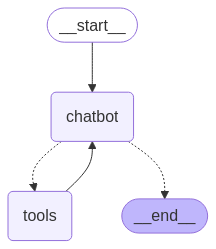

In [37]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode='values'
    )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's ChatGPT?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (abd13b34-82cf-48e9-bd06-a5de87eef656)
 Call ID: abd13b34-82cf-48e9-bd06-a5de87eef656
  Args:
    query: ChatGPT
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "ChatGPT - Wikipedia", "url": "https://en.wikipedia.org/wiki/ChatGPT", "content": "ChatGPT is a generative artificial intelligence chatbot[2][3] developed by OpenAI and launched in 2022. It is currently based on the GPT-4o large language model (LLM). ChatGPT can generate human-like conversational responses and enables users to refine and steer a conversation towards a desired length, format, style, level of detail, and language.[4] It is credited with accelerating the AI boom, which has led to ongoing rapid investment in and public att